# Species Observation Points — Data Retrieval

## Overview
The goal of this notebook is to **collect georeferenced observation points** for a set of target species relevant to our agroforestry crop systems.  
The notebook will pull together observations from multiple data sources to build a consolidated dataset of known species occurrences.

## Purpose
These observation points will be used to:
- Map the known distribution of main crops and associated companion/shade species.
- Support later steps in modelling agroforestry systems across different regions.
- Provide input data for climate suitability and biodiversity overlap analyses.

## Target Species
The species list includes:
- **Main crops**: Coffee (*Coffea arabica*), Cacao (*Theobroma cacao*), Banana (*Musa paradisiaca*).
- **Associated species**: Companion trees, fruit trees, timber species, nitrogen-fixers, and other shade-providing plants used in agroforestry systems.
- Species lists vary by **region** (e.g., Dominican Republic, Guatemala, Mexico) to reflect local agroforestry practices.

## Data Sources
We currently use three main resources:

### 1. GBIF (Global Biodiversity Information Facility)
- Public biodiversity data portal providing occurrence records for millions of species.
- Queried programmatically for each scientific name in our target species list.
- Useful for broad coverage but requires cleaning due to duplicates and variable quality.

### 2. Occurrence data from de Sousa et al. (2019)
In this step, we load the occurrence records provided in **de Sousa et al. (2019)**:  
> de Sousa, K., van Zonneveld, M., Holmgren, M., et al. *The future of coffee and cocoa agroforestry in a warmer Mesoamerica*. **Sci Rep** 9, 8828 (2019). [https://doi.org/10.1038/s41598-019-45491-7](https://doi.org/10.1038/s41598-019-45491-7)

The authors compiled a large dataset of occurrence points for:
- **Coffee** (*Coffea arabica*), which has the highest number of records.
- Various **agroforestry tree and crop species** commonly found in coffee-based systems.

### 3. Coffee data provided by the Alliance of Bioversity International and CIAT (CGIAR)
- Contains curated occurrence data for *Coffea arabica* and other coffee species.
- Provided directly by the Alliance of Bioversity International and CIAT (part of CGIAR).
- Offers more targeted and validated records compared to GBIF.

## Workflow
1. **Define species list**  
   The notebook uses a pre-defined dictionary mapping each target region to its relevant crops and associated species.

2. **Fetch and load occurrence data**  
   - Query GBIF for each target species.
   - Load and merge occurrence datasets from de Sousa et al. (2019) and CGIAR.

3. **Clean and consolidate**  
   - Remove duplicates and invalid coordinates.
   - Optionally filter by observation date or coordinate uncertainty.

4. **Export**  
   - Save the cleaned dataset as CSV/GeoJSON for later use in spatial analyses.

## Notes
- Observation counts and data quality vary greatly between species and regions.
- GBIF data is typically the starting point, but merging with de Sousa et al. (2019) and CGIAR improves coverage and reliability.
- Coordinate cleaning is essential before using these points for modelling or mapping.


In [29]:
TARGET_SPECIES = {
    "DR": {
        "Coffee": [
            {"Species": "Coffee", "Scientific name": "Coffea arabica"},
            {"Species": "Guama", "Scientific name": "Inga vera"},
            {"Species": "Bitter orange", "Scientific name": "Citrus aurantium"},
            {"Species": "Sweet orange", "Scientific name": "Citrus sinensis"},
            {"Species": "Sapote", "Scientific name": "Pouteria sapota"},
            {"Species": "Breadfruit", "Scientific name": "Artocarpus altilis"},
            {"Species": "Avocado", "Scientific name": "Persea americana"},
        ],
        "Cacao": [
            {"Species": "Cacao", "Scientific name": "Theobroma cacao"},
            {"Species": "Gliricidia (Piñón cubano)", "Scientific name": "Gliricidia sepium"},
            {"Species": "Guama", "Scientific name": "Inga vera"},
            {"Species": "Bitter orange", "Scientific name": "Citrus aurantium"},
            {"Species": "Sweet orange", "Scientific name": "Citrus sinensis"},
            {"Species": "Sapote", "Scientific name": "Pouteria sapota"},
            {"Species": "Breadfruit", "Scientific name": "Artocarpus altilis"},
            {"Species": "Avocado", "Scientific name": "Persea americana"},
        ],
        "Banana": [
            {"Species": "Banana", "Scientific name": "Musa x paradisiaca"}
        ]
    },
    "GTM": {
        "Coffee": [
            {"Species": "Coffee", "Scientific name": "Coffea arabica"},
            {"Species": "Guama", "Scientific name": "Inga edulis"},
            {"Species": "Cedar", "Scientific name": "Cedrela odorata"},
            {"Species": "Oak", "Scientific name": "Quercus spp."},
            {"Species": "Walnut", "Scientific name": "Juglans spp."},
            {"Species": "Banana", "Scientific name": "Musa paradisiaca"},
            {"Species": "Avocado", "Scientific name": "Persea americana"},
            {"Species": "Citrus", "Scientific name": "Citrus sinensis"},
            {"Species": "Pacaya", "Scientific name": "Chamaedorea spp."},
            {"Species": "Hog plum", "Scientific name": "Spondias mombin"},
        ],
        "Cacao": [
            {"Species": "Cacao", "Scientific name": "Theobroma cacao"},
            {"Species": "Guama", "Scientific name": "Inga edulis"},
            {"Species": "Gliricidia", "Scientific name": "Gliricidia sepium"},
            {"Species": "Avocado", "Scientific name": "Persea americana"},
            {"Species": "Banana", "Scientific name": "Musa paradisiaca"},
            {"Species": "Citrus", "Scientific name": "Citrus sinensis"},
            {"Species": "Erythrina", "Scientific name": "Erythrina poeppigiana"},
            {"Species": "Pigeon pea", "Scientific name": "Cajanus cajan"},
        ]
    },
    "MEX": {
        "Coffee": [
            {"Species": "Coffee", "Scientific name": "Coffea arabica"},
            {"Species": "Guava", "Scientific name": "Psidium guajava"},
            {"Species": "Guama", "Scientific name": "Inga jinicuil"},
            {"Species": "Avocado", "Scientific name": "Persea americana"},
            {"Species": "Banana", "Scientific name": "Musa paradisiaca"},
            {"Species": "Mango", "Scientific name": "Mangifera indica"},
            {"Species": "Citrus", "Scientific name": "Citrus sinensis"},
            {"Species": "Soursop", "Scientific name": "Annona muricata"},
            {"Species": "Nance", "Scientific name": "Byrsonima crassifolia"},
            {"Species": "Sapote", "Scientific name": "Pouteria sapota"},
            {"Species": "Macadamia", "Scientific name": "Macadamia integrifolia"},
            {"Species": "Papaya", "Scientific name": "Carica papaya"},
            {"Species": "Cedar", "Scientific name": "Cedrela odorata"},
            {"Species": "Mahogany", "Scientific name": "Swietenia macrophylla"},
            {"Species": "Laurel", "Scientific name": "Cordia alliodora"},
            {"Species": "Cuajinicuil", "Scientific name": "Inga jinicuil"},
        ]
    }
}


In [3]:
import pandas as pd
def clean_species_name(name: str) -> str:
    """
    Standardise species name & fix 'Coffee' to 'Coffea'.
    """
    name = name.replace('_', ' ').replace('×', '').strip()
    parts = name.split()
    if len(parts) >= 2:
        genus, species = parts[0].capitalize(), parts[1].lower()
        if genus == "Coffee":
            genus = "Coffea"
        return f"{genus} {species}"
    return name

def fetch_gbif_species(species: str, wkt_bbox: str, year_min=1960, max_records=None, delay=0.5) -> pd.DataFrame:
    """
    Fetch GBIF records newer than year_min for a species inside bbox.
    """
    all_results, offset, batch_size = [], 0, 300

    while True:
        res = gbif.search(
            scientificName=species,
            hasCoordinate=True,
            geometry=wkt_bbox,
            limit=batch_size,
            offset=offset
        )
        results = res.get("results", [])
        if not results:
            break

        filtered = [r for r in results if r.get("year") and r["year"] >= year_min]
        all_results.extend(filtered)
        offset += batch_size

        print(f"  📦 {offset} total | {len(all_results)} kept ≥{year_min} for {species}")
        if max_records and offset >= max_records:
            break
        time.sleep(delay)

    return pd.json_normalize(all_results)


def get_gbif_occurrences_for_species(species_list, wkt_bbox, year_min=1960):
    """
    Fetch GBIF occurrence records for species within bbox, filtering by year_min.
    """
    all_records = []
    for species in species_list:
        try:
            print(f"🌱 Fetching GBIF: {species}")
            records = fetch_gbif_species(species, wkt_bbox, year_min=year_min)
            if not records.empty:
                records["species_query"] = clean_species_name(species)
                all_records.append(records)
            else:
                print(f"⚠️ No records ≥{year_min} for: {species}")
        except Exception as e:
            print(f"❌ Failed for {species}: {e}")

    if all_records:
        return pd.concat(all_records, ignore_index=True)
    else:
        return pd.DataFrame(columns=["species_query", "decimalLongitude", "decimalLatitude"])

In [5]:
# 📋 Build list of target species from TARGET_SPECIES dict
target_species = sorted({
    clean_species_name(sp["Scientific name"])
    for region_data in TARGET_SPECIES.values()
    for species_list in region_data.values()
    for sp in species_list
})


In [28]:
target_species

['Annona muricata',
 'Artocarpus altilis',
 'Byrsonima crassifolia',
 'Cajanus cajan',
 'Carica papaya',
 'Cedrela odorata',
 'Chamaedorea spp.',
 'Citrus aurantium',
 'Citrus sinensis',
 'Coffea arabica',
 'Cordia alliodora',
 'Erythrina poeppigiana',
 'Gliricidia sepium',
 'Inga edulis',
 'Inga jinicuil',
 'Inga vera',
 'Juglans spp.',
 'Macadamia integrifolia',
 'Mangifera indica',
 'Musa paradisiaca',
 'Persea americana',
 'Pouteria sapota',
 'Psidium guajava',
 'Quercus spp.',
 'Spondias mombin',
 'Swietenia macrophylla',
 'Theobroma cacao']

In [16]:
import pandas as pd
from config import DATA_DIR

# 📄 Path to your Excel file (in UNU/data)
excel_path = DATA_DIR / "occurrence_data-1.xlsx"

# 🧹 Load and clean the 'Data' sheet
de_sousa = pd.read_excel(excel_path, sheet_name="Data").rename(columns={
    "lon": "decimalLongitude",
    "lat": "decimalLatitude"
})
de_sousa["species"] = de_sousa["species"].apply(clean_species_name)

# ✅ Filter to target species
de_sousa = de_sousa[de_sousa["species"].isin(target_species)]

# 🔍 Summary
print(f"✅ Excel: {len(df_excel)} records for target species.")
df_excel.head()


✅ Excel: 28894 records for target species.


,acronym,family,species_query,decimalLongitude,decimalLatitude,source,url,main_use,neotropical
5518,ANNOMU,Annonaceae,Annona muricata,-93.362194,17.979742,GBIF,https://www.gbif.org/occurrence/search?q=,Fruit,Yes
5519,ANNOMU,Annonaceae,Annona muricata,-92.045242,17.484511,GBIF,https://www.gbif.org/occurrence/search?q=,Fruit,Yes
5520,ANNOMU,Annonaceae,Annona muricata,-87.340118,21.425954,GBIF,https://www.gbif.org/occurrence/search?q=,Fruit,Yes
5521,ANNOMU,Annonaceae,Annona muricata,-92.511574,14.939840,GBIF,https://www.gbif.org/occurrence/search?q=,Fruit,Yes
5522,ANNOMU,Annonaceae,Annona muricata,-96.425490,15.914490,GBIF,https://www.gbif.org/occurrence/search?q=,Fruit,Yes


In [12]:
# 1️⃣ Get GBIF data
from shapely.geometry import box
from pygbif import occurrences as gbif
import time


cutoff_year = 1990
min_points_per_species = 100
bbox = (-115, 10, -50, 25)  # (lon_min, lat_min, lon_max, lat_max)
wkt_bbox = box(*bbox).wkt

df_gbif_recent = get_gbif_occurrences_for_species(
    species_list=target_species,
    wkt_bbox=wkt_bbox,
    year_min=cutoff_year
)

print(f"📊 GBIF records after {cutoff_year}: {len(df_gbif_recent)}")

# 2️⃣ Deduplicate
df_gbif_recent = df_gbif_recent.drop_duplicates(
    subset=["species_query", "decimalLongitude", "decimalLatitude"]
)

# 3️⃣ Summary
final_counts = df_gbif_recent.groupby("species_query").size().reset_index(name="final_count")
print(f"✅ Final dataset after deduplication: {len(df_gbif_recent)} records")
print(final_counts.sort_values("final_count", ascending=False))


🌱 Fetching GBIF: Annona muricata
  📦 300 total | 300 kept ≥1990 for Annona muricata
  📦 600 total | 600 kept ≥1990 for Annona muricata
  📦 900 total | 900 kept ≥1990 for Annona muricata
  📦 1200 total | 983 kept ≥1990 for Annona muricata
  📦 1500 total | 983 kept ≥1990 for Annona muricata
🌱 Fetching GBIF: Artocarpus altilis
  📦 300 total | 300 kept ≥1990 for Artocarpus altilis
  📦 600 total | 600 kept ≥1990 for Artocarpus altilis
  📦 900 total | 900 kept ≥1990 for Artocarpus altilis
  📦 1200 total | 1200 kept ≥1990 for Artocarpus altilis
  📦 1500 total | 1500 kept ≥1990 for Artocarpus altilis
  📦 1800 total | 1800 kept ≥1990 for Artocarpus altilis
  📦 2100 total | 1897 kept ≥1990 for Artocarpus altilis
🌱 Fetching GBIF: Byrsonima crassifolia
  📦 300 total | 300 kept ≥1990 for Byrsonima crassifolia
  📦 600 total | 600 kept ≥1990 for Byrsonima crassifolia
  📦 900 total | 900 kept ≥1990 for Byrsonima crassifolia
  📦 1200 total | 1200 kept ≥1990 for Byrsonima crassifolia
  📦 1500 total | 15

In [19]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from config import DATA_DIR

# Load CSV
df_coffee_ciat = pd.read_csv(DATA_DIR / "CoffeeCAM_anonymized.csv")



In [20]:
import numpy as np

# --- 1) GBIF recent ---
df_gb = df_gbif_recent.copy()
df_gb["source"] = df_gb.get("source", "GBIF")
if "year" not in df_gb.columns:
    df_gb["year"] = np.nan

# --- 2) De Sousa / Excel ---
df_ds = de_sousa.copy()
df_ds["source"] = df_ds.get("source", "De Sousa")
if "year" not in df_ds.columns:
    df_ds["year"] = np.nan
# ensure column naming consistency
df_ds = df_ds.rename(columns={"species": "species_query"})

# --- 3) CoffeeCAM CSV ---
df_cof = df_coffee_ciat.rename(columns={
    "Longitude": "decimalLongitude",
    "Latitude": "decimalLatitude"
})
df_cof = df_cof.assign(
    species_query=clean_species_name("Coffea arabica"),
    year=np.nan,
    source="CoffeeCAM"
)

# --- unify all columns ---
common_cols = ["species_query", "decimalLongitude", "decimalLatitude", "year", "source"]
all_parts = [
    df_gb[common_cols],
    df_ds[common_cols],
    df_cof[common_cols]
]

df_all = pd.concat(all_parts, ignore_index=True)

# --- coordinate cleaning ---
df_all = df_all.dropna(subset=["decimalLongitude", "decimalLatitude"])
df_all = df_all[
    df_all["decimalLongitude"].between(-180, 180) &
    df_all["decimalLatitude"].between(-90, 90)
]
# remove (0,0) points
df_all = df_all[~((df_all["decimalLongitude"].abs() < 1e-9) &
                  (df_all["decimalLatitude"].abs() < 1e-9))]

# --- deduplicate ---
df_all = df_all.drop_duplicates(subset=["species_query", "decimalLongitude", "decimalLatitude"]).reset_index(drop=True)

# --- summary ---
print(f"✅ Final merged dataset: {len(df_all)} records")
print(df_all.groupby("source").size().sort_values(ascending=False))
print("\nTop species:")
print(df_all.groupby("species_query").size().sort_values(ascending=False).head(10))

df_all.head()


✅ Final merged dataset: 60703 records
source
GBIF                                                                                                                       53124
CoffeeCAM                                                                                                                   2954
SpLink                                                                                                                      2134
CATIE Inventories                                                                                                            917
ICMBio                                                                                                                       601
Boshier and Lamb (1997)                                                                                                      253
OSINFOR                                                                                                                      207
SINCHI                                              

,species_query,decimalLongitude,decimalLatitude,year,source
0,Annona muricata,-73.787033,11.239887,2025.0,GBIF
1,Annona muricata,-84.167708,10.040435,2025.0,GBIF
2,Annona muricata,-85.033944,10.885278,2025.0,GBIF
3,Annona muricata,-61.129347,14.679253,2025.0,GBIF
4,Annona muricata,-69.201520,19.292958,2025.0,GBIF


In [22]:
import numpy as np
import pandas as pd

# Ensure year is numeric so we can keep the newest
if "year" in df_all.columns:
    df_all["year"] = pd.to_numeric(df_all["year"], errors="coerce").astype("Int64")
else:
    df_all["year"] = np.nan

# 1) Drop exact coordinate duplicates per species
df_all = df_all.drop_duplicates(subset=["species_query", "decimalLongitude", "decimalLatitude"])

# 2) Drop near-duplicates within ~1 km using a 0.01° grid (~1.1 km N–S; ~1.1 km * cos(lat) E–W)
#    Sort so the newest year is kept when collapsing cells.
df_all = df_all.sort_values(["species_query", "year"], ascending=[True, False]).copy()
cell_deg = 0.01  # ≈1.1 km; set to 0.009 for ~1.0 km

df_all["_lon_cell"] = (df_all["decimalLongitude"] / cell_deg).round().astype("Int64")
df_all["_lat_cell"]  = (df_all["decimalLatitude"]  / cell_deg).round().astype("Int64")

df_all = (
    df_all
    .drop_duplicates(subset=["species_query", "_lon_cell", "_lat_cell"])
    .drop(columns=["_lon_cell", "_lat_cell"])
    .reset_index(drop=True)
)

print(f"✅ Cleaned: {len(df_all)} records after exact + ~1 km de-dup")
print(df_all.groupby("species_query").size().sort_values(ascending=False).head(10))


✅ Cleaned: 47306 records after exact + ~1 km de-dup
species_query
Inga edulis              8580
Coffea arabica           4014
Psidium guajava          3938
Byrsonima crassifolia    3564
Inga vera                3172
Persea americana         2681
Carica papaya            2610
Cedrela odorata          2601
Mangifera indica         2380
Gliricidia sepium        2117
dtype: int64


In [24]:
gdf

,species_query,decimalLongitude,decimalLatitude,year,source,geometry
0,Annona muricata,-73.787033,11.239887,2025,GBIF,POINT (-73.78703 11.23989)
1,Annona muricata,-84.167708,10.040435,2025,GBIF,POINT (-84.16771 10.04044)
2,Annona muricata,-85.033944,10.885278,2025,GBIF,POINT (-85.03394 10.88528)
3,Annona muricata,-61.129347,14.679253,2025,GBIF,POINT (-61.12935 14.67925)
4,Annona muricata,-69.201520,19.292958,2025,GBIF,POINT (-69.20152 19.29296)
...,...,...,...,...,...,...
47301,Theobroma cacao,33.458300,-2.125000,<NA>,GBIF,POINT (33.45830 -2.12500)
47302,Theobroma cacao,3.541700,9.041700,<NA>,GBIF,POINT (3.54170 9.04170)
47303,Theobroma cacao,-0.708300,6.041700,<NA>,GBIF,POINT (-0.70830 6.04170)
47304,Theobroma cacao,12.125000,8.625000,<NA>,GBIF,POINT (12.12500 8.62500)


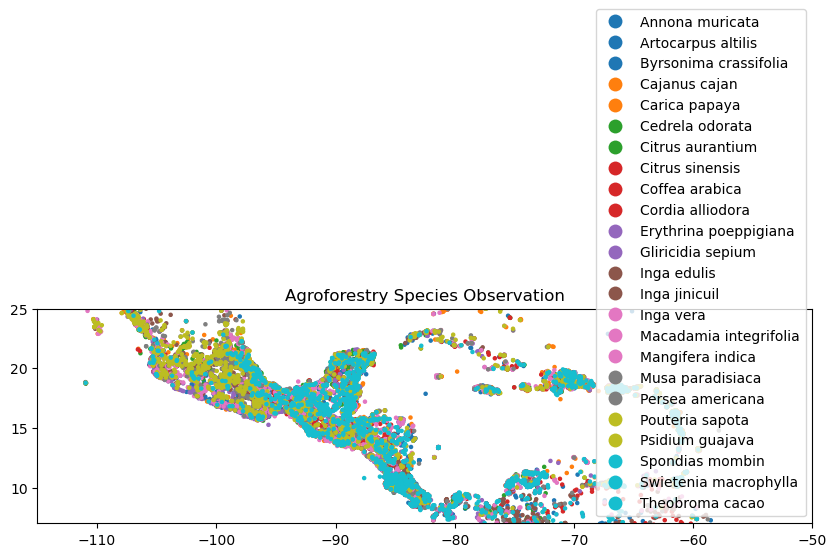

In [26]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Quick map of points, coloured by source
gdf = gpd.GeoDataFrame(
    df_all,
    geometry=gpd.points_from_xy(df_all["decimalLongitude"], df_all["decimalLatitude"]),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, column="species_query", categorical=True, legend=True, markersize=5)
ax.set_xlim(-115, -50)
ax.set_ylim(7, 25)
ax.set_title("Agroforestry Species Observation")
plt.show()


In [27]:
# 📄 Save combined cleaned dataset
output_path = DATA_DIR / "species_occurrences_combined_cleaned.csv"
df_all.to_csv(output_path, index=False)

print(f"✅ Saved combined dataset to: {output_path}")
print(f"📊 Final number of records: {len(df_all)}")


✅ Saved combined dataset to: /Users/szelie/data/unu/species_occurrences_combined_cleaned.csv
📊 Final number of records: 47306
